# Predictor de Popularidade de Músicas

**Índice**<a id='toc0_'></a>    
1. [Introdução](#toc1_)    
2. [Preparação do notebook para R e Python em sumultâneo](#toc2_)    
3. [Script R Madalena](#toc3_)    
4. [Importação dos módulos](#toc4_)    
5. [Exploração dos dados em bruto](#toc5_)    
5.1. [Upload dos dados](#toc5_1_)    
5.2. [Criação do dataframe](#toc5_2_)    
5.3. [Visualização do dataframe em bruto e de algumas métricas](#toc5_3_)    
6. [Análise Exploratória](#toc6_)    
6.1. [Distribuição dos valores em cada coluna](#toc6_1_)    
7. [Pré-processamento dos dados](#toc7_)    
7.1. [Identificação de Valores Ausentes](#toc7_1_)    
7.2. [Remoção de musicas com tempo 0](#toc7_2_)    
7.3. [Identificação e remoção de duplicados](#toc7_3_)    
7.4. [Definir o índice](#toc7_4_)    
7.5. [Remover coluna song_name](#toc7_5_)    
7.6. [Definir variáveis categóricas e variáveis numéricas](#toc7_6_)    
7.7. [Método do intervalo interquartil (IQR) para filtrar outliers](#toc7_7_)    
7.8. [Estatísticas do dataset](#toc7_8_)    
7.9. [Standerização dos dados](#toc7_9_)    
8. [Divisão em conjunto de treino e conjunto de teste](#toc8_)    
9. [Implementação de algoritmos de Aprendizagem Computacional](#toc9_)    
9.1. [Random Forest](#toc9_1_)    
9.1.1. [Treino inicial do modelo](#toc9_1_1_)    
9.1.2. [Afinação dos hiperparâmetros com o GridSearchCV](#toc9_1_2_)    
9.1.3. [Configurar e executar o GridSearchCV](#toc9_1_3_)    
9.1.4. [Treino do modelo com os melhores hiperparâmetros](#toc9_1_4_)    
10. [Resultados](#toc10_)    
11. [Considerações finais](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introdução](#toc0_)

## 2. <a id='toc2_'></a>[Preparação do notebook para R e Python em sumultâneo](#toc0_)

In [ ]:
# ! R -e "install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()"

In [ ]:
# ! pip install rpy2

In [98]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
#%%R -i df_no_outliers
#head(df_no_outliers) #Exemplo de utilização

## 3. <a id='toc3_'></a>[Script R Madalena](#toc0_)

In [ ]:
%%R
data=read.csv("data/song_data.csv")
head(data)
data.numeric <- data[,sapply(data, is.numeric)]

head(data.numeric)
install.packages("pls")
library(pls)
library(psych) 
library(readr)
library(tree)
library(caret)
library(gbm)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(pROC)
library(ggplot2)
library(reshape2)

In [ ]:
%%R 
quartiles <- quantile(data$song_popularity, probs = c(0, 0.25, 0.5, 0.75, 0.95), na.rm = TRUE)
breaks <- c(quartiles[1:5], Inf)
labels <- c("Não_popular", "Pouco_popular", "Rádio_amigável", "Popular", "Viral")
data$song_category <- cut(data$song_popularity, breaks = breaks, labels = labels, include.lowest = TRUE)
summary(data$song_category)
data$song_name<-NULL
head(data)

In [ ]:
%%R
hist(data$song_duration_ms)
hist(data$acousticness)
hist(data$tempo)
correlation_matrix <- cor(data.numeric)
correlation_data <- melt(correlation_matrix)

In [ ]:
%%R
ggplot(correlation_data, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), 
                       space = "Lab", name="Correlation") +
  geom_text(aes(label = round(value, 2)), color = "black", size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) +
  coord_fixed() +
  labs(title = "Correlation Heatmap", x = "Variables", y = "Variables")

In [ ]:
%%R
boxplot(data$song_duration_ms)

boxplot(data$instrumentalness)
ggplot(data, aes(x = song_category, y = song_duration_ms)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "song_duration_ms")


threshold <- 1000000  # limite dos outliers (limite)
data <- data[data$song_duration_ms <= threshold, ]
dim(data)
18835-18831 ##4 outliers eliminados

#####Variavel acousticness

ggplot(data, aes(x = song_category, y = acousticness)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Acousticness")

# Definir o limite (threshold)
threshold1 <- 0.98
data <- data[!(data$song_category == "Popular" & data$acousticness > threshold1), ]
head(data)
18835-18814 ##21 outliers eliminados


#####Variavel Energy
##Não é preciso eliminar outliers

ggplot(data, aes(x = song_category, y = energy
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Energy")


#####Variavel Speechiness

ggplot(data, aes(x = song_category, y = speechiness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Speechiness")

threshold1 <- 0.9  
threshold2 <- 0.9 
threshold3 <- 0.75
threshold4 <- 0.5
data <- data[!(data$song_category == "Not_popular" & data$speechiness > threshold1), ]
data <- data[!(data$song_category == "Low_popularity" & data$speechiness > threshold2), ]
data <- data[!(data$song_category == "Radio_friendly" & data$speechiness > threshold3), ]
data <- data[!(data$song_category == "Popular" & data$speechiness > threshold4), ]

dim(data)
18831-18794 ##37 outliers eliminados

####Variavel Loudness

ggplot(data, aes(x = song_category, y = loudness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Loudness")
threshold1=-35
data <- data[!(data$loudness < threshold1), ]
dim(data)
18831-18788 ##43 outliers eliminados

####Variavel Speechiness

ggplot(data, aes(x = song_category, y = speechiness
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Speechiness")

threshold1=0.85
data <- data[!(data$speechiness > threshold1), ]
dim(data)
18831-18783 ##48 outliers eliminados


##Variavel Tempo
ggplot(data, aes(x = song_category, y = tempo
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Tempo")
threshold1=230
threshold2=0
data <- data[!(data$tempo > threshold1), ]
data <- data[!(data$tempo <= threshold2), ]
dim(data)
18831-18780 ##51 outliers eliminados


##Variavel Danceability
ggplot(data, aes(x = song_category, y = danceability
)) +
  geom_boxplot() +
  labs(title = "Box plot of Your Variable by Song Category",
       x = "Song Category",
       y = "Danceability")


In [ ]:
%%R
df <- data.frame(data)

## 4. <a id='toc4_'></a>[Importação dos módulos](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


## 5. <a id='toc5_'></a>[Exploração dos dados em bruto](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Upload dos dados](#toc0_)

In [187]:
data = pd.read_csv('data/song_data.csv')

### 5.2. <a id='toc5_2_'></a>[Criação do dataframe](#toc0_)

In [188]:
df_raw = pd.DataFrame(data)

In [189]:
df_raw

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 5.3. <a id='toc5_3_'></a>[Visualização do dataframe em bruto e de algumas métricas](#toc0_)

In [ ]:
#TESTE COM DATASET DA MADALENA
df_no_outliers = %R df

In [190]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [191]:
df_raw.shape

(18835, 15)

## 6. <a id='toc6_'></a>[Análise Exploratória](#toc0_)

### 6.1. <a id='toc6_1_'></a>[Distribuição dos valores em cada coluna](#toc0_)

In [192]:
col_names = df_raw.columns

col_names

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [193]:
col_counts = {}

for col in col_names:
    col_counts[col] = df_raw[col].value_counts()

col_counts


{'song_name': song_name
 Better                                            21
 FEFE (feat. Nicki Minaj & Murda Beatz)            19
 MIA (feat. Drake)                                 18
 Taki Taki (with Selena Gomez, Ozuna & Cardi B)    18
 No Stylist                                        17
                                                   ..
 Bassride                                           1
 The Beat                                           1
 We Are the Brave - Fatum Remix                     1
 Long Live House Music                              1
 Up to Me                                           1
 Name: count, Length: 13070, dtype: int64,
 'song_popularity': song_popularity
 58     404
 52     389
 55     388
 60     383
 63     378
       ... 
 98      47
 97      36
 93      32
 99      16
 100     12
 Name: count, Length: 101, dtype: int64,
 'song_duration_ms': song_duration_ms
 165000    25
 180000    21
 212500    20
 189000    20
 179404    19
           ..
 219682 

## 7. <a id='toc7_'></a>[Pré-processamento dos dados](#toc0_)

### 7.1. <a id='toc7_1_'></a>[Identificação de Valores Ausentes](#toc0_)

In [194]:
df_raw.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

### 7.2. <a id='toc7_2_'></a>[Remoção de musicas com tempo 0](#toc0_)

In [195]:
df_raw.drop(df_raw[(df_raw['tempo']==0)].index, inplace=True)

### 7.3. <a id='toc7_3_'></a>[Identificação e remoção de duplicados](#toc0_)

In [196]:
# Remover duplicatas considerando todas as colunas
df_raw.drop_duplicates(inplace=True)


In [197]:
df_raw.shape

(14924, 15)

### 7.4. <a id='toc7_4_'></a>[Definir o índice](#toc0_)

In [198]:
df_raw.set_index(pd.RangeIndex(start=1, stop=len(df_raw)+1, step=1), inplace=True)

### 7.5. <a id='toc7_5_'></a>[Remover coluna song_name](#toc0_)

In [199]:
df_raw.drop(columns='song_name', inplace=True)


In [200]:
df_raw

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
1,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
2,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
3,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
4,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
5,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14920,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
14921,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
14922,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
14923,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 7.6. <a id='toc7_6_'></a>[Definir variáveis categóricas e variáveis numéricas](#toc0_)

In [201]:
from sklearn.compose import make_column_selector as selector
numerical_columns_selector = selector(dtype_exclude='category')
categorical_columns_selector = selector(dtype_include='category')

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [95]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_raw) 
df_raw.loc[:,:] = scaled_values

In [202]:
df_raw

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
1,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
2,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
3,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
4,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
5,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14920,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
14921,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
14922,23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
14923,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 7.7. <a id='toc7_7_'></a>[Método do intervalo interquartil (IQR) para filtrar outliers](#toc0_)

In [126]:
numeric_columns = df_raw.select_dtypes(include='number')

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define os limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Identifica e remove outliers
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
df_no_outliers = df_raw[~outliers]

### Remoção de outliers com o z-score

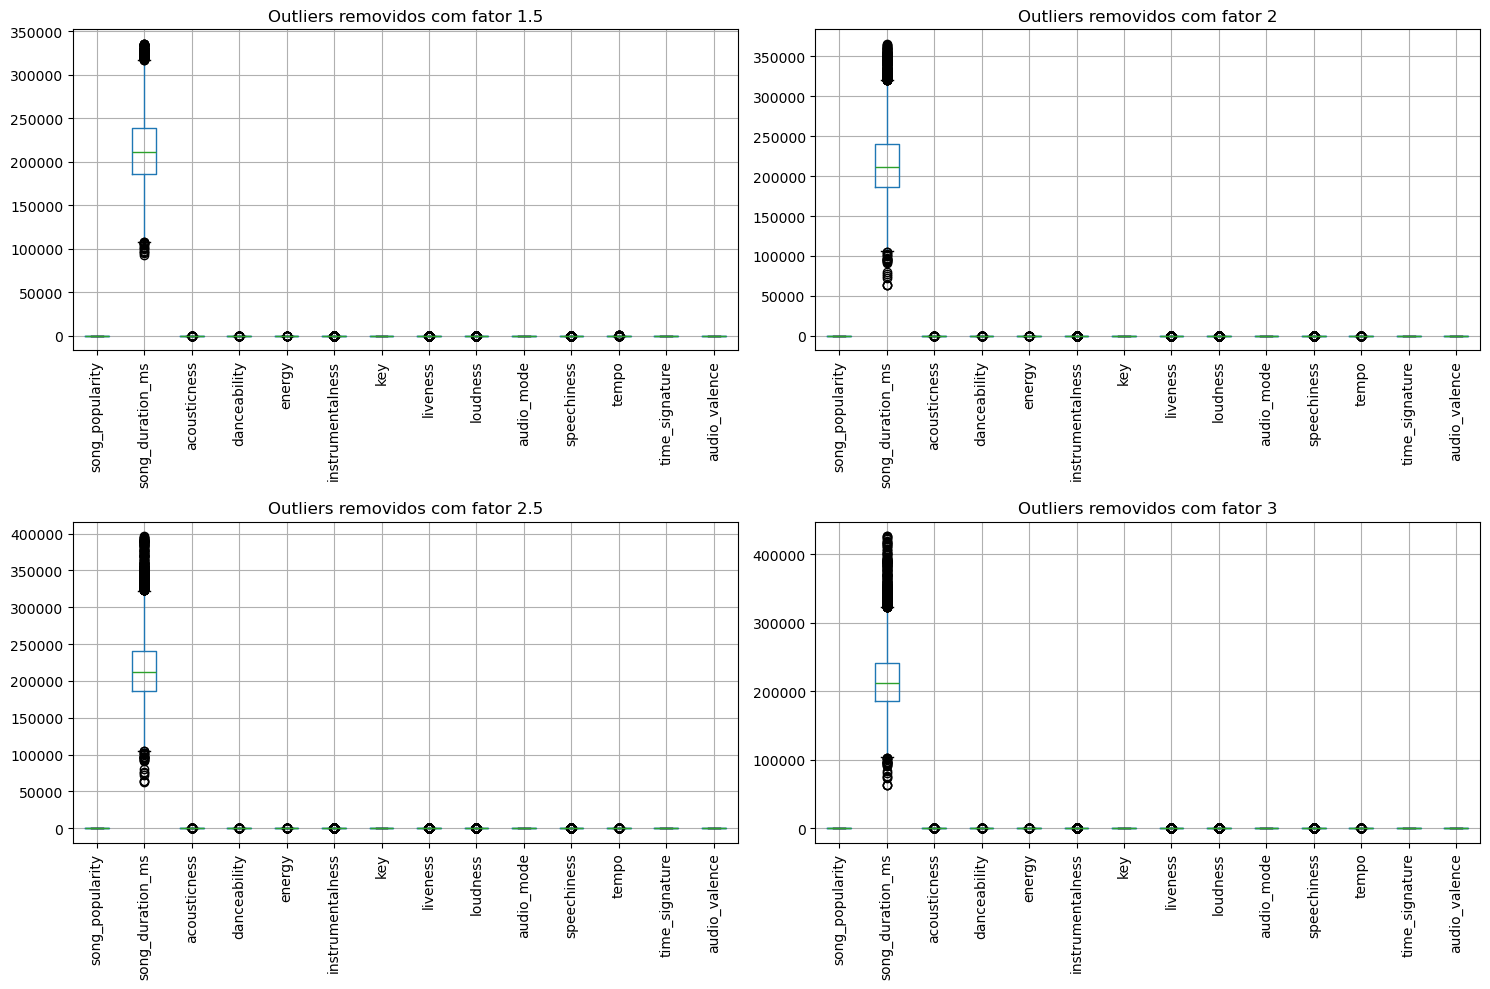

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

# Função para calcular e remover outliers com limite ajustável
def remove_outliers(df, factor):
    numeric_columns = df.select_dtypes(include='number')
    Q1 = numeric_columns.quantile(0.25)
    Q3 = numeric_columns.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
    return df[~outliers]

# Analisar diferentes fatores para remoção de outliers
factors = [1.5, 2, 2.5, 3]
dfs_no_outliers = {factor: remove_outliers(df_raw, factor) for factor in factors}

# Visualizar impacto da remoção de outliers para cada fator
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for ax, factor in zip(axes, factors):
    numeric_columns_after = dfs_no_outliers[factor].select_dtypes(include='number')
    numeric_columns_after.boxplot(ax=ax)
    ax.set_title(f'Outliers removidos com fator {factor}')
    ax.set_xticklabels(numeric_columns_after.columns, rotation=90)

plt.tight_layout()
plt.show()

# Avaliar o melhor fator
# Pode-se incluir análises adicionais aqui, como métricas de desempenho, distribuição dos dados, etc.


In [127]:
df_no_outliers

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_name,,,,,,,,,,,,,,
Boulevard of Broken Dreams,0.73,0.133179,0.005541,0.470677,0.682342,0.000029,0.727273,0.049226,0.859242,1.0,0.007620,0.615495,0.8,0.469303
In The End,0.66,0.107575,0.010340,0.520267,0.853697,0.000000,0.272727,0.099580,0.801948,0.0,0.029828,0.299729,0.8,0.361082
By The Way,0.74,0.107575,0.026505,0.422165,0.970940,0.003561,0.000000,0.093426,0.838352,1.0,0.092097,0.387545,0.8,0.182102
How You Remind Me,0.56,0.111462,0.000957,0.417853,0.766517,0.000000,0.909091,0.104707,0.835204,1.0,0.009689,0.640790,0.8,0.573361
Bring Me To Life,0.80,0.118267,0.008985,0.276628,0.945888,0.000002,0.363636,0.394934,0.882190,0.0,0.110603,0.732347,0.8,0.309053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Let It Breathe,0.60,0.075266,0.896586,0.474989,0.150241,0.000066,1.000000,0.102656,0.561569,1.0,0.013499,0.344245,0.8,0.288241
Answers,0.60,0.101220,0.768072,0.469599,0.160262,0.000001,1.000000,0.096503,0.611850,0.0,0.008382,0.243681,0.8,0.251821
Sudden Love (Acoustic),0.23,0.087993,0.850401,0.711082,0.324602,0.000000,0.000000,0.117014,0.657845,1.0,0.014261,0.428878,0.8,0.273673


In [128]:
df_no_outliers.shape

(10393, 14)

Inferência:

Antes da remoção de duplicados e outliers, o conjunto de dados tinha 18835 amostras.

Após a remoção de duplicados e outliers, o conjunto de dados ficou com 8609 amostras.

### 7.8. <a id='toc7_8_'></a>[Estatísticas do dataset](#toc0_)

In [ ]:
import matplotlib.pyplot as plt

# Definindo as cores
colors = ['green', 'red']  # Exemplo de cores: azul e laranja

plt.title('Dataset Final')
plt.pie([df_no_outliers.shape[0], df_raw.shape[0]-df_no_outliers.shape[0]], 
        radius=1, 
        labels=['Mantido', 'Excluído'], 
        counterclock=False, 
        autopct='%1.1f%%', 
        pctdistance=0.9, 
        explode=[0.02, 0], 
        shadow=False,
        colors=colors)  # Adicionando a lista de cores
plt.show()


In [ ]:
df_no_outliers.describe()

/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_84452/3872272152.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_raw['song_popularity'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)


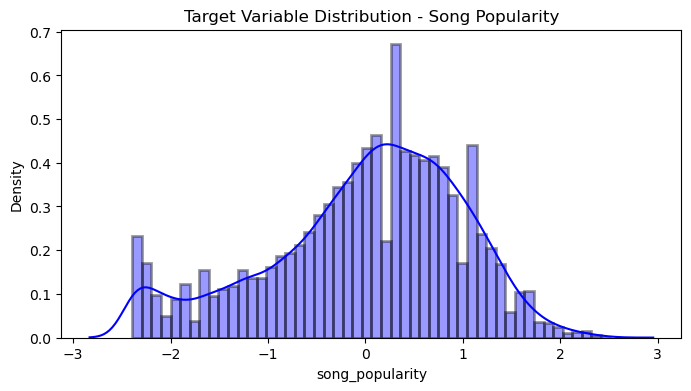

In [94]:
plt.figure(figsize=[8,4])
sns.distplot(df_raw['song_popularity'], color='b',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Target Variable Distribution - Song Popularity')
plt.show()

/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_84452/3488089894.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_raw['song_popularity'], color='black',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)


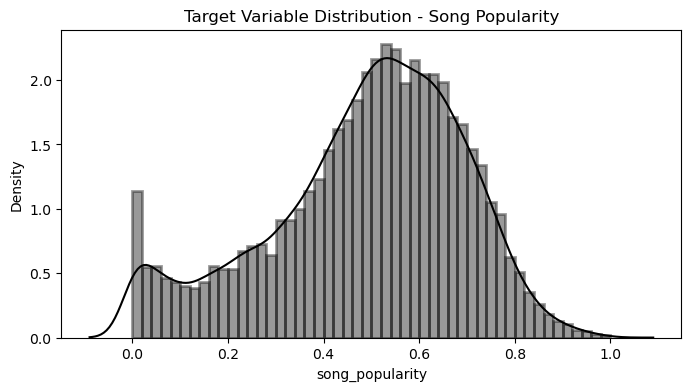

In [91]:
plt.figure(figsize=[8,4])
sns.distplot(df_no_outliers['song_popularity'], color='black',hist_kws=dict(edgecolor="black", linewidth=2), bins=50)
plt.title('Target Variable Distribution - Song Popularity')
plt.show()

In [ ]:
# Configurar a figura com duas subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

# Plotar o primeiro gráfico
sns.histplot(df_no_outliers['song_popularity'], color='black', edgecolor="black", linewidth=2, bins=50, ax=axes[0])
axes[0].set_title('Target Variable Distribution - Song Popularity')

# Plotar o segundo gráfico
sns.histplot(df_no_outliers['song_popularity'], color='b', edgecolor="black", linewidth=2, bins=50, ax=axes[1])
axes[1].set_title('Target Variable Distribution - Song Popularity (No Outliers)')

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [76]:
# Splitting the data intro training & testing sets

from sklearn.model_selection import train_test_split

m=[]
for i in df_normalized.columns.values:
    m.append(i.replace(' ','_'))
    
df_normalized.columns = m
X = df_normalized[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence']]
X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
Y = df_normalized["song_popularity"]



/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_84452/499746710.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.727273, 0.272727, 0.000000, 0.000000, 0.909091, ..., 1.000000, 1.000000, 0.000000, 0.272727, 0.363636]
Length: 14924
Categories (12, float64): [0.000000, 0.090909, 0.181818, 0.272727, ..., 0.727273, 0.818182, 0.909091, 1.000000]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_84452/499746710.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 0.0, 1.0, 1.0, 1.0, ..., 1.0, 0.0, 1.0, 1.0, 1.0]
Length: 14924
Categories (2, float64): [0.0, 1.0]' has dtype incompatible with float64, please expl

### 7.9. <a id='toc7_9_'></a>[Standerização dos dados](#toc0_)

In [77]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [78]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('One-Hot-Encoder', categorical_preprocessor, categorical_columns),
    ('Standard-Scaler', numerical_preprocessor, numerical_columns)])

## 8. <a id='toc8_'></a>[Divisão em conjunto de treino e conjunto de teste](#toc0_)

In [79]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
Train_X.reset_index(drop=True,inplace=True)

print('Conjunto original (100%): ',X.shape,Y.shape,'\nConjunto de treino (80%): ',Train_X.shape,Train_Y.shape,'\nConjunto de teste (20%): ', Test_X.shape,'', Test_Y.shape)

Conjunto original (100%):  (14924, 13) (14924,) 
Conjunto de treino (80%):  (11939, 13) (11939,) 
Conjunto de teste (20%):  (2985, 13)  (2985,)


## 9. <a id='toc9_'></a>[Implementação de algoritmos de Aprendizagem Computacional](#toc0_)

### 9.1. <a id='toc9_1_'></a>[Random Forest](#toc0_)

#### 9.1.1. <a id='toc9_1_1_'></a>[Treino inicial do modelo](#toc0_)

In [80]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

# Escolha RandomForestClassifier para problemas de classificação e RandomForestRegressor para regressão
model = make_pipeline(preprocessor,RandomForestRegressor(random_state=21))  # ou RandomForestRegressor
set_config(display='diagram')

# Treinar o modelo
model.fit(Train_X, Train_Y)

# Fazer previsões
Pred_Y = model.predict(Test_X)



In [81]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('One-Hot-Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('Standard-Scaler',
                                                  StandardScaler(),
                                                  ['song_duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'instrumentalness', 'key',
                                                   'liveness', 'loudness',
                                                   'audio_mode', 'speechiness',
                                                   'tempo', 'time_signature',
                                                   'audio_valence'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=21))])

In [82]:
def modelresults(predictions):
    mae = mean_absolute_error(Test_Y, predictions)
    mse = mean_squared_error(Test_Y, predictions)
    r2 = r2_score(Test_Y, predictions)
    
    print('Erro absoluto médio do modelo: {:.4f}'.format(mae))
    print('')
    print('Erro quadrático médio do modelo: {:.4f}'.format(mse))
    print('')
    print('O valor de r2 do modelo: {:.4f}'.format(r2))

In [83]:
modelresults(Pred_Y)

Erro absoluto médio do modelo: 0.1576

Erro quadrático médio do modelo: 0.0398

O valor de r2 do modelo: 0.0118


#### 9.1.2. <a id='toc9_1_2_'></a>[Afinação dos hiperparâmetros com o GridSearchCV](#toc0_)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árvores in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de features a serem consideradas para divisão
    'max_depth': [None, 10, 20, 30],      # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],      # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]         # Número mínimo de amostras num nó folha
}


#### 9.1.3. <a id='toc9_1_3_'></a>[Configurar e executar o GridSearchCV](#toc0_)

In [ ]:
# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=21), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Executar o GridSearchCV
grid_search.fit(Train_X, Train_Y)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f"Melhor estimador: {best_estimator}")
print(f'Melhores hiperparâmetros: {best_params}')


#### 9.1.4. <a id='toc9_1_4_'></a>[Treino do modelo com os melhores hiperparâmetros](#toc0_)

In [ ]:
# Criar um novo modelo com os melhores hiperparâmetros
#best_model = RandomForestClassifier(**best_params, random_state=42)  # ou RandomForestRegressor
best_model = RandomForestRegressor(**best_params, random_state=42)  # ou RandomForestRegressor

# Treinar o modelo
best_model.fit(Train_X, Train_Y)

# Fazer previsões
Best_Pred_Y = best_model.predict(Test_X)


In [ ]:
modelresults(Best_Pred_Y)

## 10. <a id='toc10_'></a>[Resultados](#toc0_)

## 11. <a id='toc11_'></a>[Considerações finais](#toc0_)